# Deep Portfolio - autoencoder

Select a subset of stocks from IBB Index to re-track the Index.

IBB Index is index composed of U.S.-listed equities in the biotechnology sector.
We have 83 stocks

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

In [26]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = 'https://drive.google.com/file/d/1p-26QERZ4oSkQnhkGkGKpDJc_M9phRQx'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('last_price.csv')

link = 'https://drive.google.com/file/d/1dTSWQjn5IP2htgDoC4Sll5siAUSy3rZ6'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('net_change.csv')

link = 'https://drive.google.com/file/d/1LL_T_1IUdJBRkLY5xeQYYYicPrYwQO8t'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('percentage_change.csv')

link = 'https://drive.google.com/file/d/1-WzRWqJA65MvNAjothI_H_ojb6XjWQWv'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ibb.csv')

In [ ]:
pwd

'/content'

In [27]:
ls

drive/   last_price.csv  percentage_change.csv
ibb.csv  net_change.csv  sample_data/


In [28]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

Phase 1: Autoencoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization

Overfitiing:
- Overfitting refers to the phenomenon where a neural network models the training data very well but fails when it sees new data from the same problem domain

2-norm difference: 
- Computed $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder 

L2 Regularization
- The L2 regularization is the most common type of all regularization techniques.
- reducing overfitting 

ReLU 
- Rectified Linear Unit
- Activation function used to output the input directly if it is positive, otherwise, it will output zero.



In [29]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)       #'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
11/11 [==============================] - 1s 3ms/step - loss: 6.0294
Epoch 2/500
11/11 [==============================] - 0s 3ms/step - loss: 5.6099
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 5.4769
Epoch 4/500
11/11 [==============================] - 0s 3ms/step - loss: 5.4120
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 5.3659
Epoch 6/500
11/11 [==============================] - 0s 3ms/step - loss: 5.3255
Epoch 7/500
11/11 [==============================] - 0s 3ms/step - loss: 5.2858
Epoch 8/500
11/11 [==============================] - 0s 3ms/step - loss: 5.2438
Epoch 9/500
11/11 [==============================] - 0s 3ms/step - loss: 5.1964
Epoch 10/500
11/11 [==============================] - 0s 3ms/step - loss: 5.1414
Epoch 11/500
11/11 [==============================] - 0s 4ms/step - loss: 5.0772
Epoch 12/500
11/11 [==============================] - 0s 3ms/step - loss: 5.0016
Epoch 13/500
11/11 [=================

In [30]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest difference to highest

stock #, 2-norm, stock name
68 1.3014928102493286 TLGT    US Equity
65 1.3613529205322266 INO     US Equity
38 1.5868483781814575 LXRX    US Equity
76 1.7983646392822266 NVAX    US Equity
66 2.096567153930664 CERS    US Equity
79 2.164501428604126 ZGNX    US Equity
81 2.38960862159729 MNOV    US Equity
77 2.417844295501709 PDLI    US Equity
71 2.4955101013183594 CRIS    US Equity
52 2.791414976119995 IMMU    US Equity
17 2.83522629737854 EXEL    US Equity
49 3.0193467140197754 DEPO    US Equity
75 3.1072781085968018 GERN    US Equity
37 3.4946482181549072 ARRY    US Equity
73 3.60087513923645 AVDL    US Equity
67 3.669137954711914 PACB    US Equity
48 3.929543972015381 SGYP    US Equity
19 4.026002407073975 OPK     US Equity
42 4.1822075843811035 RGEN    US Equity
72 4.214558124542236 PRTK    US Equity
31 4.287267684936523 HZNP    US Equity
55 4.297126293182373 BCRX    US Equity
82 4.350195407867432 ARWR    US Equity
80 4.600325584411621 CGEN    US Equity
44 4.859154224395752 FOLD    U

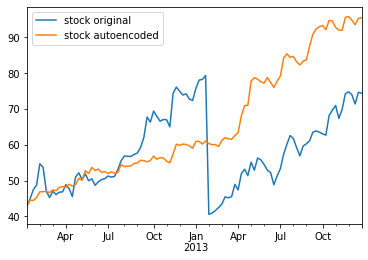

In [32]:
which_stock = 1

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

Phase 2: Caliberating

In [33]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
11/11 [==============================] - 1s 3ms/step - loss: 5.4601
Epoch 2/500
11/11 [==============================] - 0s 2ms/step - loss: 3.1829
Epoch 3/500
11/11 [==============================] - 0s 5ms/step - loss: 2.3945
Epoch 4/500
11/11 [==============================] - 0s 3ms/step - loss: 2.0002
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 1.7277
Epoch 6/500
11/11 [==============================] - 0s 5ms/step - loss: 1.5037
Epoch 7/500
11/11 [==============================] - 0s 6ms/step - loss: 1.3116
Epoch 8/500
11/11 [==============================] - 0s 5ms/step - loss: 1.1625
Epoch 9/500
11/11 [==============================] - 0s 2ms/step - loss: 1.0580
Epoch 10/500
11/11 [==============================] - 0s 2ms/step - loss: 0.9797
Epoch 11/500
11/11 [==============================] - 0s 2ms/step - loss: 0.9190
Epoch 12/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8703
Epoch 13/500
11/11 [=================

S25 2-norm difference:  19.953098
S45 2-norm difference:  5.2329793
S65 2-norm difference:  4.3842063


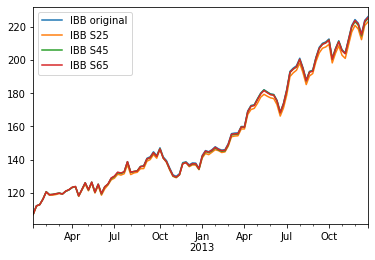

In [34]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    

Phase 3: Validating

In [35]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

S25 2-norm difference:  1299.2478
S45 2-norm difference:  475.97592
S65 2-norm difference:  184.2115


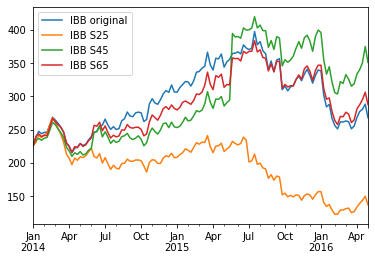

In [36]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].to_numpy(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

Phase 4: Verifying

In [37]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 1s 4ms/step - loss: 6.6671
Epoch 2/500
11/11 [==============================] - 0s 3ms/step - loss: 2.9570
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 1.6989
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 1.2455
Epoch 5/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0079
Epoch 6/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8430
Epoch 7/500
11/11 [==============================] - 0s 3ms/step - loss: 0.7233
Epoch 8/500
11/11 [==============================] - 0s 2ms/step - loss: 0.6354
Epoch 9/500
11/11 [==============================] - 0s 2ms/step - loss: 0.5632
Epoch 10/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5061
Epoch 11/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4592
Epoch 12/500
11/11 [==============================] - 0s 3ms/step - loss: 0.419

Text(0, 0.5, 'number of stocks in the portfolio')

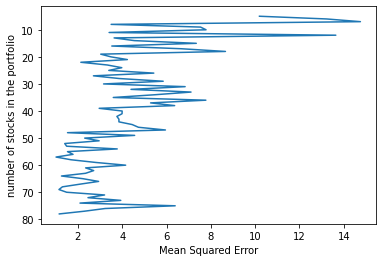

In [38]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 


# Part 2

Autoencoding

In [39]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/beat_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
11/11 [==============================] - 0s 2ms/step - loss: 5.8471
Epoch 2/500
11/11 [==============================] - 0s 2ms/step - loss: 5.6582
Epoch 3/500
11/11 [==============================] - 0s 2ms/step - loss: 5.5461
Epoch 4/500
11/11 [==============================] - 0s 2ms/step - loss: 5.4591
Epoch 5/500
11/11 [==============================] - 0s 2ms/step - loss: 5.3815
Epoch 6/500
11/11 [==============================] - 0s 2ms/step - loss: 5.3042
Epoch 7/500
11/11 [==============================] - 0s 2ms/step - loss: 5.2212
Epoch 8/500
11/11 [==============================] - 0s 2ms/step - loss: 5.1266
Epoch 9/500
11/11 [==============================] - 0s 2ms/step - loss: 5.0240
Epoch 10/500
11/11 [==============================] - 0s 2ms/step - loss: 4.9143
Epoch 11/500
11/11 [==============================] - 0s 2ms/step - loss: 4.8014
Epoch 12/500
11/11 [==============================] - 0s 2ms/step - loss: 4.6865
Epoch 13/500
11/11 [=================

In [40]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different 

stock #, 2-norm, stock name
68 1.2721045017242432 TLGT    US Equity
65 1.320670485496521 INO     US Equity
38 1.635454535484314 LXRX    US Equity
76 1.7996901273727417 NVAX    US Equity
66 2.081266164779663 CERS    US Equity
79 2.1744697093963623 ZGNX    US Equity
81 2.400442361831665 MNOV    US Equity
77 2.4043428897857666 PDLI    US Equity
71 2.4690182209014893 CRIS    US Equity
17 2.829993486404419 EXEL    US Equity
52 2.8327324390411377 IMMU    US Equity
49 3.0926153659820557 DEPO    US Equity
75 3.0960655212402344 GERN    US Equity
37 3.4173948764801025 ARRY    US Equity
73 3.6509957313537598 AVDL    US Equity
67 3.65156626701355 PACB    US Equity
48 3.8855092525482178 SGYP    US Equity
19 3.9988410472869873 OPK     US Equity
42 4.156242847442627 RGEN    US Equity
72 4.19263219833374 PRTK    US Equity
55 4.193519592285156 BCRX    US Equity
31 4.282261848449707 HZNP    US Equity
82 4.328713417053223 ARWR    US Equity
80 4.608404159545898 CGEN    US Equity
69 4.859434127807617 RIGL 

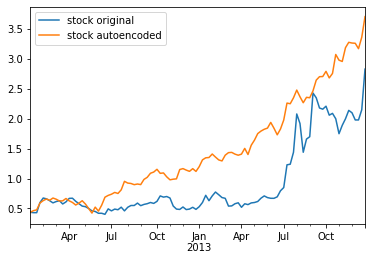

In [42]:
which_stock = 65

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

Phase 2: Calibrating

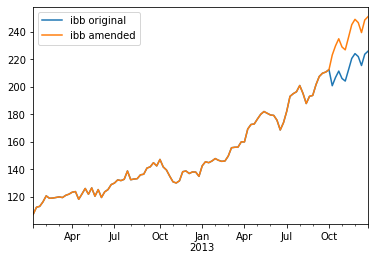

In [45]:
# from -5% to 5%
y_amended = ibb['calibrate']['percentage']
y_amended[y_amended < -5] = 5

# re-calculate the last price
y_amended[0] = 0
relative_percentage = (y_amended /100) + 1
lp_amended = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod()) 

# plot comparison
pd.Series(ibb['calibrate']['lp'].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb amended', legend=True) 

In [46]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.005))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = y_amended # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - lp_amended)) # compare with amended last price

Epoch 1/500
11/11 [==============================] - 1s 2ms/step - loss: 5.9690
Epoch 2/500
11/11 [==============================] - 0s 2ms/step - loss: 3.3455
Epoch 3/500
11/11 [==============================] - 0s 3ms/step - loss: 2.4804
Epoch 4/500
11/11 [==============================] - 0s 2ms/step - loss: 2.0528
Epoch 5/500
11/11 [==============================] - 0s 2ms/step - loss: 1.7985
Epoch 6/500
11/11 [==============================] - 0s 2ms/step - loss: 1.6200
Epoch 7/500
11/11 [==============================] - 0s 3ms/step - loss: 1.4903
Epoch 8/500
11/11 [==============================] - 0s 2ms/step - loss: 1.3841
Epoch 9/500
11/11 [==============================] - 0s 3ms/step - loss: 1.3086
Epoch 10/500
11/11 [==============================] - 0s 3ms/step - loss: 1.2505
Epoch 11/500
11/11 [==============================] - 0s 2ms/step - loss: 1.1985
Epoch 12/500
11/11 [==============================] - 0s 3ms/step - loss: 1.1576
Epoch 13/500
11/11 [=================

S25 2-norm difference:  27.626863
S45 2-norm difference:  54.18659
S65 2-norm difference:  16.512722


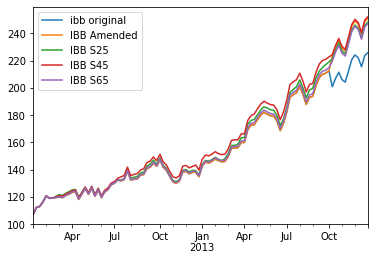

In [47]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.to_numpy(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB Amended', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])  

Phase 3: Validating

In [48]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/beat_s' + str(s) + '.h5')
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
#     total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

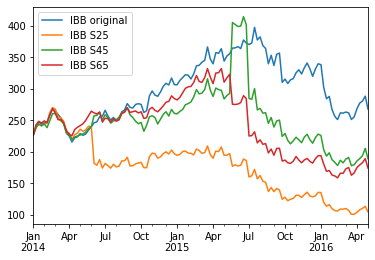

In [50]:
# plot original IBB last price
pd.Series(ibb['validate']['lp'].to_numpy(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

# 2-norm difference is now meaningless to compare
for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)

Phase 4: Verifying (Extra)

In [51]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))  

Streaming output truncated to the last 5000 lines.
11/11 [==============================] - 0s 3ms/step - loss: 9.4824
Epoch 2/500
11/11 [==============================] - 0s 3ms/step - loss: 4.8573
Epoch 3/500
11/11 [==============================] - 0s 3ms/step - loss: 3.7273
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 2.6635
Epoch 5/500
11/11 [==============================] - 0s 2ms/step - loss: 1.9152
Epoch 6/500
11/11 [==============================] - 0s 3ms/step - loss: 1.4944
Epoch 7/500
11/11 [==============================] - 0s 3ms/step - loss: 1.2163
Epoch 8/500
11/11 [==============================] - 0s 2ms/step - loss: 1.0397
Epoch 9/500
11/11 [==============================] - 0s 2ms/step - loss: 0.9108
Epoch 10/500
11/11 [==============================] - 0s 5ms/step - loss: 0.8174
Epoch 11/500
11/11 [==============================] - 0s 3ms/step - loss: 0.7346
Epoch 12/500
11/11 [==============================] - 0s 3ms/step - loss: 0.669

Text(0, 0.5, 'number of stocks in the portfolio')

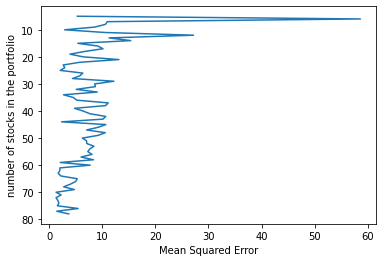

In [52]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 